In [1]:
# Import PyTorch
import torch
torch.backends.cudnn.benchmark = True

from torch import nn
from torch.cuda.amp import autocast, GradScaler

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

torch.backends.cudnn.benchmark = True

from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 54.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.94MB/s]


In [3]:
image, label = train_data[0]

class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Image shape: torch.Size([1, 28, 28])


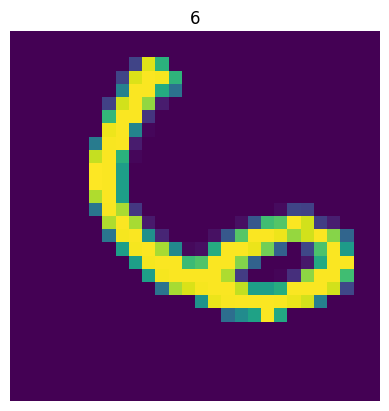

In [4]:
import matplotlib.pyplot as plt
image, label = train_data[torch.randint(0, len(train_data), size=[1]).item()]
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
plt.title(label);
plt.axis("off")
plt.show()

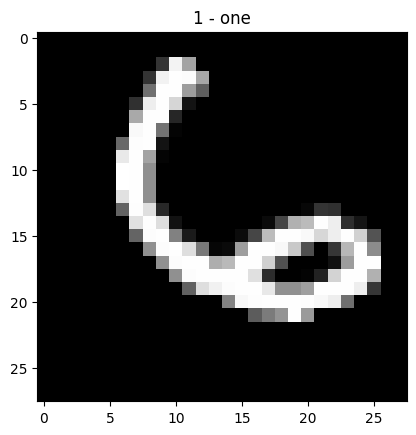

In [40]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

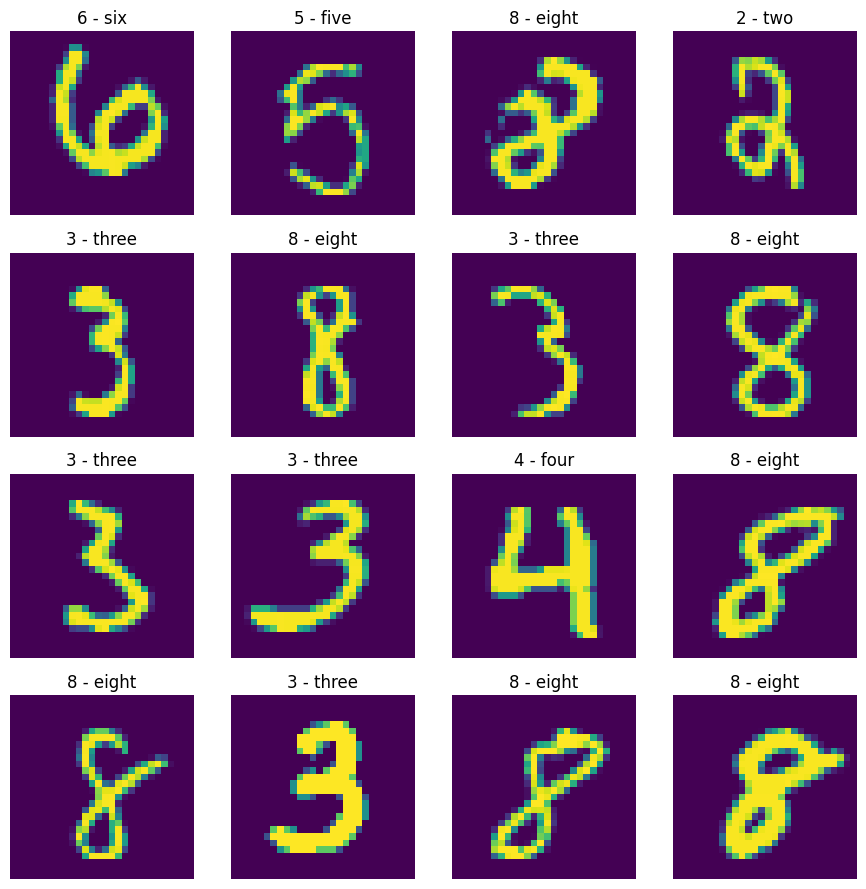

In [42]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]

    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [6]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []

    model.eval()

    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Send the model to the device as well
            model.to(device)

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True, # shuffle data every epoch?
    num_workers = 2,
    pin_memory=True
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # don't necessarily have to shuffle the testing data
    num_workers = 2,
    pin_memory=True
)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a110f3b7990>, <torch.utils.data.dataloader.DataLoader object at 0x7a110f3b7710>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [10]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [14]:
class LeNet_5(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2), # 14x14

        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2), # 5x5
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=16*4*4, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=10),
    )

  def forward(self, x):
    return self.classifier(self.feature(x))

model = LeNet_5()
model.to(device)

LeNet_5(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=120, bias=True)
    (2): Tanh()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Tanh()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [15]:
# Make predictions on test samples with model
pred_probs = make_predictions(model=model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[0.0987, 0.1076, 0.1032, 0.0892, 0.1018, 0.0929, 0.0873, 0.1088, 0.1128,
         0.0976],
        [0.0965, 0.1072, 0.1028, 0.0913, 0.1010, 0.0948, 0.0866, 0.1076, 0.1136,
         0.0987]])

In [16]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8])

In [17]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [18]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam (params=model.parameters(), lr=0.001)

In [28]:
# Corrected train_step function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

    model.train()
    torch.set_grad_enabled(True)

    train_loss, train_acc = 0, 0
    scaler = GradScaler()

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass and loss calculation within autocast for mixed precision
        with autocast():
          y_pred = model(X)
          loss = loss_fn(y_pred, y)

        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad - MOVED BEFORE backward pass
        optimizer.zero_grad()

        # 4. Loss backward (handled by scaler)
        scaler.scale(loss).backward()

        # 5. Optimizer step (handled by scaler)
        scaler.step(optimizer)
        scaler.update()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    # Return the calculated metrics
    return train_loss, train_acc

# The test_step function remains the same as it doesn't involve optimization
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

    # Return the calculated metrics
    return test_loss, test_acc

In [72]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn)
        test_loss, test_acc = test_step(model=model,
            data_loader=test_dataloader, # Changed 'dataloader' to 'data_loader'
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [73]:
from timeit import default_timer as timer
train_time_start_model = timer()

model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=5)

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-28-b0a3b3d63123>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-28-b0a3b3d63123>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train loss: 0.01059 | Train accuracy: 99.62%
Test loss: 0.04706 | Test accuracy: 98.77%

Epoch: 1 | train_loss: 0.0106 | train_acc: 99.6250 | test_loss: 0.0471 | test_acc: 98.7720
Train loss: 0.00798 | Train accuracy: 99.73%
Test loss: 0.04852 | Test accuracy: 98.69%

Epoch: 2 | train_loss: 0.0080 | train_acc: 99.7333 | test_loss: 0.0485 | test_acc: 98.6921
Train loss: 0.01201 | Train accuracy: 99.59%
Test loss: 0.04050 | Test accuracy: 98.80%

Epoch: 3 | train_loss: 0.0120 | train_acc: 99.5867 | test_loss: 0.0405 | test_acc: 98.8019
Train loss: 0.00857 | Train accuracy: 99.72%
Test loss: 0.04168 | Test accuracy: 98.88%

Epoch: 4 | train_loss: 0.0086 | train_acc: 99.7233 | test_loss: 0.0417 | test_acc: 98.8818
Train loss: 0.00790 | Train accuracy: 99.75%
Test loss: 0.04358 | Test accuracy: 98.84%

Epoch: 5 | train_loss: 0.0079 | train_acc: 99.7533 | test_loss: 0.0436 | test_acc: 98.8419
Train time on cpu: 155.526 seconds


In [74]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

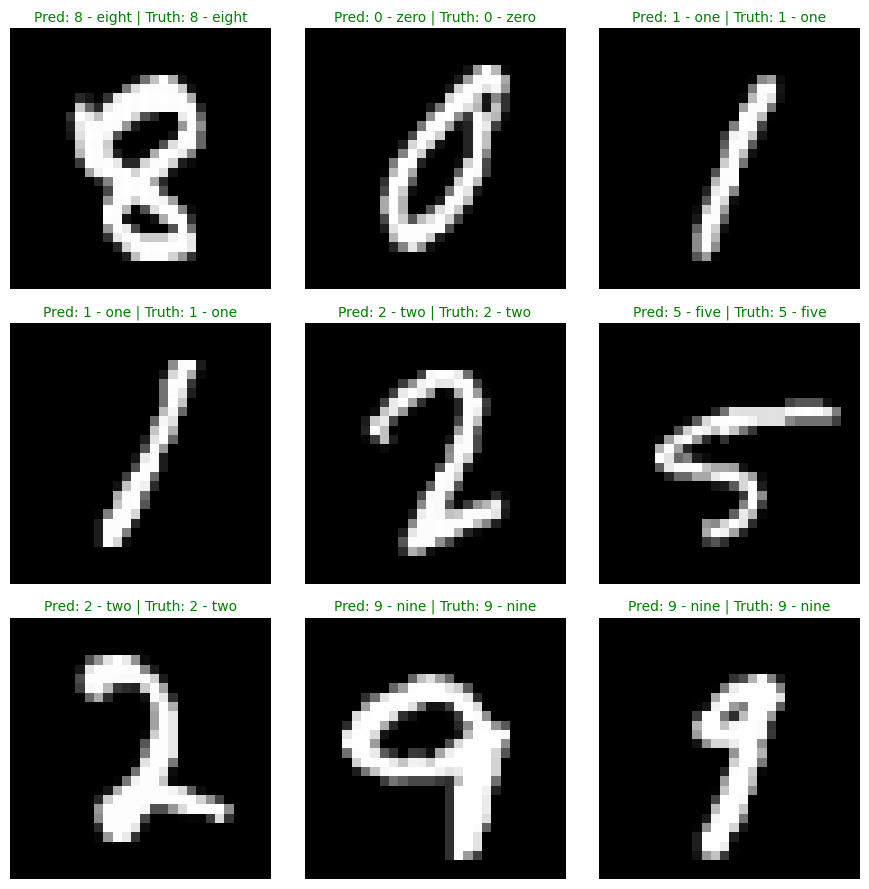

In [87]:
# Plot random predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

# Get random sample indices
random_indices = random.sample(range(len(test_data)), k=nrows * ncols)

for i, sample_idx in enumerate(random_indices):
    # Get a random sample and its truth label
    sample, truth_label_idx = test_data[sample_idx] # sample is a tensor [1, 28, 28] with values in [0, 1]

    # Make a prediction on the random sample
    # make_predictions expects a list of samples, so we pass [sample]
    pred_prob_sample = make_predictions(model=model, data=[sample])
    pred_class_sample = pred_prob_sample.argmax(dim=1)
    pred_label = class_names[pred_class_sample]

    # Get the truth label in text form
    truth_label = class_names[truth_label_idx]

    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    # For a single channel MNIST image, permute is not strictly necessary for imshow
    # Squeeze removes the channel dimension: [1, 28, 28] -> [28, 28]
    # Use 'gray' colormap for grayscale images
    plt.imshow(sample.squeeze(), cmap='gray') # Removed the potentially incorrect unnormalization

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if wrong
    plt.axis(False)

plt.tight_layout()
plt.show()

In [78]:
model.eval()
y_preds = []
with torch.inference_mode():
    for X, y in test_dataloader:
        X = X.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1).cpu()          # class indices
        y_preds.append(preds)
y_pred_tensor = torch.cat(y_preds)                # shape [10000]

# Convert true labels to a tensor
test_targets_tensor = torch.tensor(test_data.targets, dtype=torch.long)

<ipython-input-78-ca98e7f67b5a>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_targets_tensor = torch.tensor(test_data.targets, dtype=torch.long)


<ipython-input-79-06f5d9b6f936>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_targets_tensor = torch.tensor(test_data.targets).long()


Unique values in y_pred_tensor: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Counts of unique values: tensor([ 984, 1131, 1037, 1019,  979,  896,  956, 1016,  977, 1005])


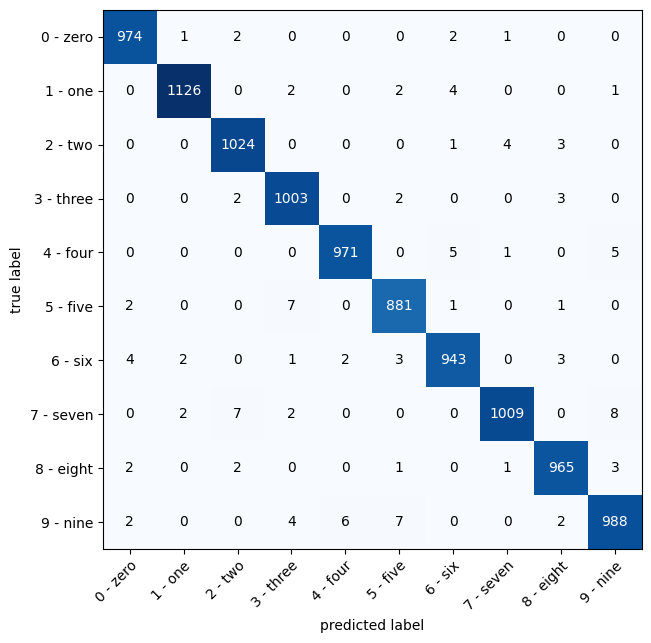

In [79]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torch # Ensure torch is imported if not already in this cell

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

# Convert test_data.targets from a list to a torch tensor
# Ensure both predictions and targets are of type long
test_targets_tensor = torch.tensor(test_data.targets).long()
y_pred_tensor = y_pred_tensor.long() # Explicitly cast predictions to long

# --- Add inspection code here ---
unique_preds, counts = torch.unique(y_pred_tensor, return_counts=True)
print(f"Unique values in y_pred_tensor: {unique_preds}")
print(f"Counts of unique values: {counts}")
# --- End inspection code ---


confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_targets_tensor) # Pass the tensor version of targets

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [80]:
from typing import Dict, List
import matplotlib.pyplot as plt # Added import as it's used in the function

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

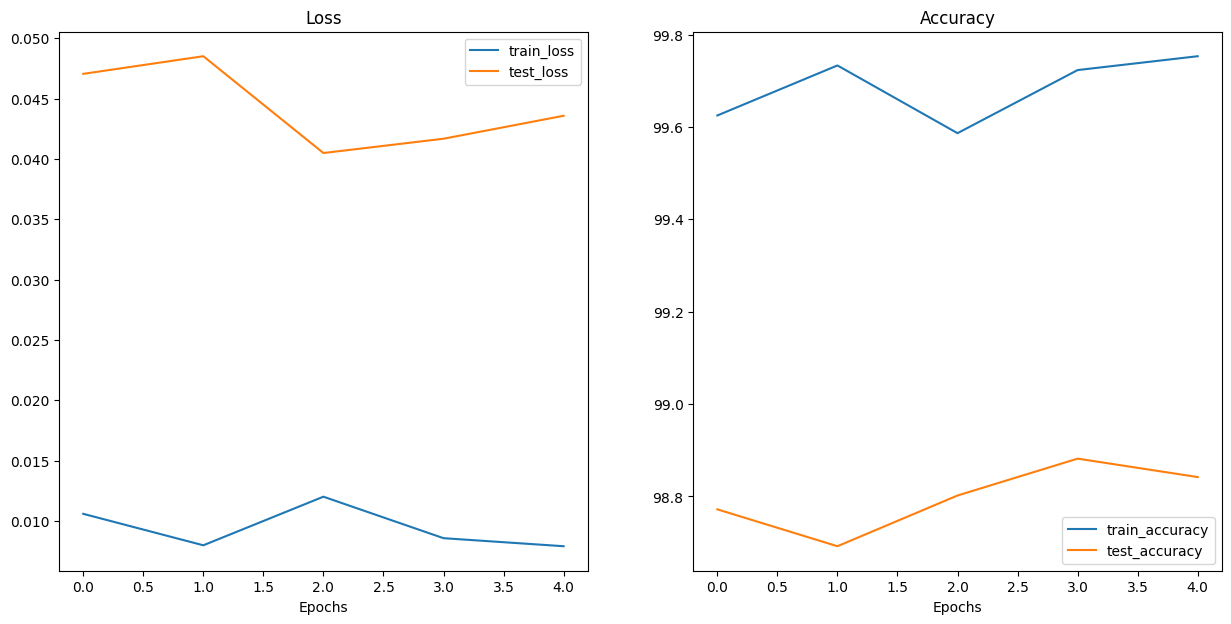

In [84]:
plot_loss_curves(model_results)

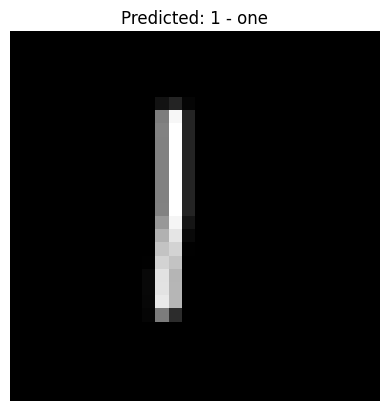

In [82]:
from IPython.display import clear_output, display, HTML
import base64
from io import BytesIO

html_code = '''
<canvas id="canvas" width="280" height="280" style="border:1px solid #000;"></canvas><br>
<button onclick="clearCanvas()">Clear</button>
<button onclick="sendCanvas()">Predict</button>
<script>
  const canvas = document.getElementById('canvas');
  const ctx = canvas.getContext('2d');
  // initialize BLACK background
  ctx.fillStyle = 'black';
  ctx.fillRect(0,0,280,280);
  // white paint
  ctx.strokeStyle = 'white';
  ctx.lineWidth = 15;
  let drawing = false;
  canvas.onmousedown = e => (drawing=true, ctx.beginPath(), ctx.moveTo(e.offsetX,e.offsetY));
  canvas.onmousemove = e => drawing && (ctx.lineTo(e.offsetX,e.offsetY), ctx.stroke());
  canvas.onmouseup   = () => drawing=false;
  function clearCanvas(){
    ctx.fillStyle = 'black';
    ctx.fillRect(0,0,280,280);
  }
  function sendCanvas(){
    const data = canvas.toDataURL('image/png');
    google.colab.kernel.invokeFunction('predict_image', [data], {});
    clearCanvas();
  }
</script>
'''

# Callback: clears previous output, re-display blank canvas, preprocess as grayscale, predict, show result
def handle_image(image_data):
    clear_output(wait=True)
    display(HTML(html_code))
    header, encoded = image_data.split(',', 1)
    decoded = base64.b64decode(encoded)
    img = Image.open(BytesIO(decoded)).resize((28,28)).convert('L')  # grayscale
    tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
    model.eval()
    with torch.inference_mode():
        logits = model(tensor)
        pred   = torch.softmax(logits, dim=1).argmax(dim=1).item()
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {class_names[pred]}")
    plt.axis('off')
    plt.show()

output.register_callback('predict_image', handle_image)
display(HTML(html_code))

In [88]:
# Specify a file path within the /content/ directory
model_save_path = '/content/lenet5_mnist.pth'

# Save the model state dictionary to the specified file path
torch.save(model.state_dict(), model_save_path)

print(f"Model state dictionary saved to {model_save_path}")

Model state dictionary saved to /content/lenet5_mnist.pth
